In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Scegliamo alcuni parametri
n = 100 # dimensione del problema
sigma = 0 # 0.01 # std del rumore gaussiano

x_true = np.linspace(0, 1, n) # soluzione esatta

# STEP 1: Costruire un problema test della forma
#   Ax = y, con soluzione esatta x_true, e matrice
#   A della forma:
#
#   A = |-2  1   0|
#       |1  -2   1|
#       |0  1   -2|
#
# e aggiungere a y rumore gaussiano con deviazione standard sigma
A = np.zeros((n, n))
for i in range(n):
    A[i, i] = -2 # diagonale
    
    if (i+1) < n:
        A[i, i+1] = 1 # sovradiagonale
        A[i+1, i] = 1 # sottodiagonale

y = A @ x_true # problema test
y = y + sigma * np.random.normal(0, 1, (n, ))

In [25]:
# STEP 2: Verificare che la matrice A non sia troppo mal condizionata
print(np.linalg.cond(A))

4133.642926800066


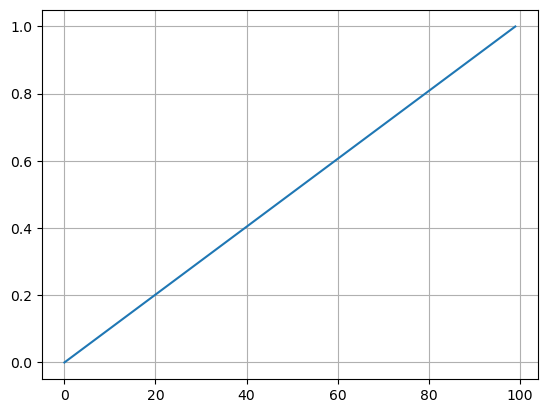

In [26]:
# STEP 3: Risolvere il sistema delle equazioni normali associato ad A tramite metodo di Cholesky.
L = np.linalg.cholesky(A.T @ A)
z = np.linalg.solve(L, A.T @ y)

x_chol = np.linalg.solve(L.T, z)

plt.plot(x_chol)
plt.grid()
plt.show()

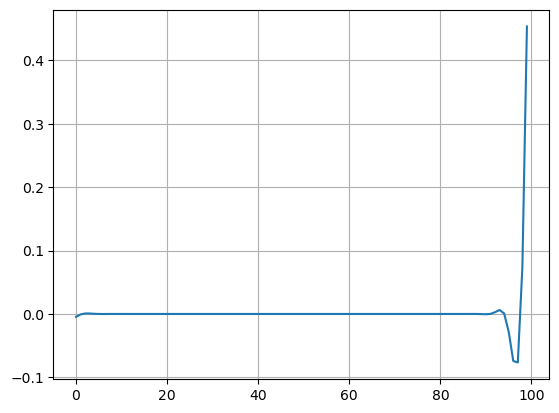

In [27]:
# STEP 4: Risolvere il problema dei minimi quadrati utilizzando Discesa del Gradiente ad una tolleranza fissata di tolf = tolx = 1e-6, utilizzando SIA il metodo a passo fisso che con backtracking.
# Nel caso di passo fisso, scegliere alpha in modo adeguato.
def GD(f, df, x0, x_true, alpha, maxit=100, tolf=1e-6, tolx=1e-6):
    r"""
    Implementa il metodo di discesa del gradiente con passo fisso applicato ad una funzione f(x) della quale si conosce la derivata df(x). 

    Parameters:
    f (function): la funzione obiettivo che si vuole minimizzare
    df (function): la derivata (o gradiente) della funzione obiettivo
    x0 (ndarray): valore iniziale dell'algoritmo
    x_true (ndarray): la soluzione esatta dell'algoritmo (nota SOLO in fase di test)
    alpha (float): il passo fisso che descrive gli step dell'algoritmo
    maxit (int): numero di iterazioni
    tolf (float): tolleranza di || grad(f) ||_2
    tolx (float): tolleranza di || x_{k+1} - x_k ||_2
    """
    # Inizializzazione
    k = 0
    rel_err = np.zeros((maxit+1, ))
    obj_val = np.zeros((maxit+1, ))
    grad_norm = np.zeros((maxit+1, ))

    # Ciclo iterativo (uso un ciclo while)
    condizione = True
    while condizione:
        # Aggiornamento x_{k+1} = x_k - alpha_k df(x_k)
        x = x0 - alpha * df(x0)

        # Calcolo dell'errore e salvataggio
        rel_err[k] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        obj_val[k] = f(x)
        grad_norm[k] = np.linalg.norm(df(x))

        # Check condizioni di arresto
        condizione = (k < maxit) and (np.linalg.norm(df(x)) > tolf) and (np.linalg.norm(x - x0) > tolx)

        # Se l'algoritmo termina per || x_{k+1} - x_k || < tolx, stampare il warning
        if (np.linalg.norm(x - x0) < tolx):
            print(f"Algoritmo terminato per condizione su tolx.")
            
        # Preparazione per step successivo
        k = k + 1
        x0 = x

    # Se l'algoritmo si ferma prima di maxit, tagliare i valori inutilizzati delle metriche
    if k < maxit:
        rel_err = rel_err[:k]
        obj_val = obj_val[:k]
        grad_norm = grad_norm[:k]

    return x, rel_err, obj_val, grad_norm


def f(x):
    return 1/2 * np.linalg.norm(A @ x - y)**2

def df(x):
    return A.T @ (A @ x - y)

x_GD, _, _, _ = GD(f, 
                   df, 
                   x0=np.zeros_like(x_true),
                   x_true=x_true,
                   alpha=0.001,
                   maxit=1000,
                   tolf=1e-6,
                   tolx=1e-6)
plt.plot(x_GD)
plt.grid()
plt.show()

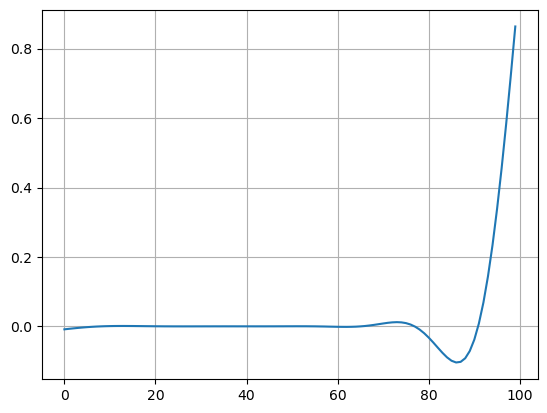

In [30]:
def backtracking(f, df, x, alpha=1, rho=0.5, c=1e-4):
    """
    Algoritmo di backtracking per Discesa Gradiente.

    Parameters:
    f       : Funzione obiettivo.
    df      : Gradiente della funzione obiettivo.
    x       : Iterato x_k.
    alpha   : Stima iniziale di alpha(default 1).
    rho     : Fattore di riduzione (default 0.5).
    c       : Costante delle condizioni di Armijo (default 1e-4).

    Returns:
    alpha   : Learning rate calcolato con backtracking.
    """
    while f(x - alpha * df(x)) > f(x) + c * alpha * np.linalg.norm(df(x))**2:
        alpha *= rho
    return alpha

def GD_backtracking(f, df, x0, x_true, maxit=100, tolf=1e-6, tolx=1e-6):
    r"""
    Implementa il metodo di discesa del gradiente con passo scelto con backtracking applicato ad una funzione f(x) della quale si conosce la derivata df(x). 

    Parameters:
    f (function): la funzione obiettivo che si vuole minimizzare
    df (function): la derivata (o gradiente) della funzione obiettivo
    x0 (ndarray): valore iniziale dell'algoritmo
    x_true (ndarray): la soluzione esatta dell'algoritmo (nota SOLO in fase di test)
    maxit (int): numero di iterazioni
    tolf (float): tolleranza di || grad(f) ||_2
    tolx (float): tolleranza di || x_{k+1} - x_k ||_2
    """
    # Inizializzazione
    k = 0
    rel_err = np.zeros((maxit+1, ))
    obj_val = np.zeros((maxit+1, ))
    grad_norm = np.zeros((maxit+1, ))

    # Ciclo iterativo (uso un ciclo while)
    condizione = True
    while condizione:
        # Scelta di alpha_k con backtracking
        alpha = backtracking(f, df, x0, alpha=1)

        # Aggiornamento x_{k+1} = x_k - alpha_k df(x_k)
        x = x0 - alpha * df(x0)

        # Calcolo dell'errore e salvataggio
        rel_err[k] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        obj_val[k] = f(x)
        grad_norm[k] = np.linalg.norm(df(x))

        # Check condizioni di arresto
        condizione = (k < maxit) and (np.linalg.norm(df(x)) > tolf) and (np.linalg.norm(x - x0) > tolx)

        # Se l'algoritmo termina per || x_{k+1} - x_k || < tolx, stampare il warning
        if (np.linalg.norm(x - x0) < tolx):
            print(f"Algoritmo terminato per condizione su tolx.")
            
        # Preparazione per step successivo
        k = k + 1
        x0 = x

    # Se l'algoritmo si ferma prima di maxit, tagliare i valori inutilizzati delle metriche
    if k < maxit:
        rel_err = rel_err[:k]
        obj_val = obj_val[:k]
        grad_norm = grad_norm[:k]

    return x, rel_err, obj_val, grad_norm

x_GD_backtracking, _, obj_val, _ = GD_backtracking(f,
                                    df,
                                    x0=np.zeros_like(x_true),
                                    x_true=x_true,
                                    maxit=2000,
                                    tolf=1e-6,
                                    tolx=1e-6)
plt.plot(x_GD_backtracking)
plt.grid()
plt.show()